# Using XGBoost in Python Tutorial

## Motivation
If you clicked on this, chances are you already know XGBoost is awesome and can get the job done. If you are looking for some proof, how about this visual from the Kaggle State of Data Science survey, where almost 50% of respondents say they use the library:

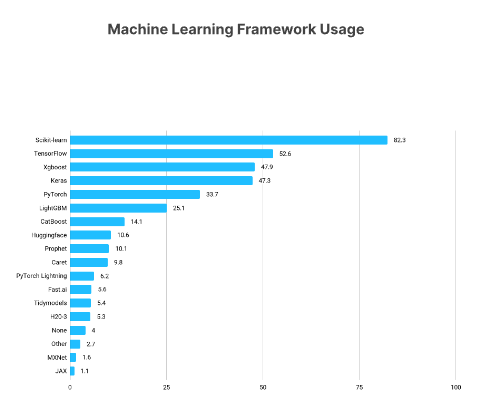

It only ranks below TensorFlow and Sklearn. So, without boring you about more reasons why you should learn it, let's get straight to the meat of the article.

## What you will learn in this tutorial

In this tutorial, you will learn how to effectively use one of the most powerful machine learning frameworks in the Python ecosystem. The topics covered are:

- Installation
- XGBoost DMatrix class
- XGBoost regression
- Objective and loss functions in XGBoost
- Building training and evaluation loops
- Cross validation in XGBoost
- Building an XGBoost classifier
- Changing between Sklearn and native APIs of XGBoost

Let's get started!

## Installation

XGBoost can be installed like any other library through `pip`. This method of installation will also include support for your machine's NVIDIA GPU. If you want to install CPU only version, you can go with `conda-forge`:

```python
$ pip install --user xgboost 
# CPU only
$ conda install -c conda-forge py-xgboost-cpu
# Use NVIDIA GPU
$ conda install -c conda-forge py-xgboost-gpu
```

> I hope I don't have to tell you that the library should be installed in a virtual environment.

I strongly recommend to run through the examples in the tutorial with GPU-enabled machine. If you don't have one, you can check out alternatives like [Google Colab](https://colab.research.google.com/) or [DataCamp Workspace](https://www.datacamp.com/workspace).

If you decide to go with Colab, it has the old version of XGBoost installed, so you should call `pip install --upgrade xgboost` to get the latest version.

## Loading and exploring the data

We will be working with the Diamonds dataset throughout the tutorial. It has a nice combination of numeric and categorical features and over 50k observations that we can comfortably showcase all the advantages of XGBoost. 

```python
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

diamonds = sns.load_dataset("diamonds")
diamonds.head()
```

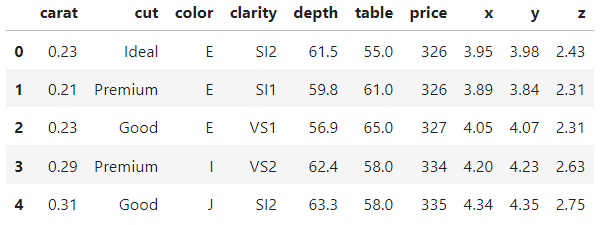

```python
>>> diamonds.shape
```

```
(53940, 10)
```

In a typical real-world project, you would want to spend a lot more time exploring the dataset and visualizing its features. But since this data comes built-in to Seaborn, it is relatively clean.

So, we will just look at the 5-number summary of the numeric and categorical features and get going. Spend a few moments to familiarize yourself.

```python
diamonds.describe()
```

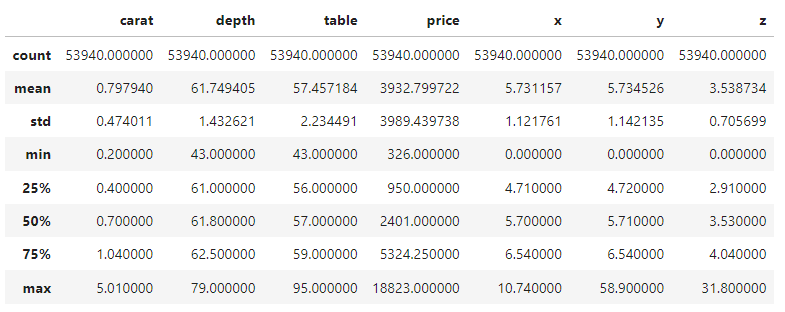

```python
diamonds.describe(exclude=np.number)
```

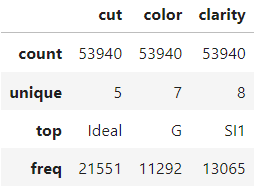

## Building an XGBoost DMatrix

After you are done exploration, the first step in any project is framing the machine learning problem and extract the feature and target arrays based on the dataset.

In this tutorial, we will first try to predict Diamond prices using their physical measurements, so our target will be the `price` column. 

So, we are isolating the features into `X` and the target into `y`:

```python
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
```

The dataset has three categorical columns. Normally, you would encode them with ordinal or one-hot encoding but XGBoost has the ability to internally deal with categoricals.

The way to enable this feature is to cast the categorical columns into Pandas `category` data type (by default, they are treated as text columns):

```python
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')
```

Now, when you see the `dtypes` attribute,  you'll see that we have three `category` features:

```
>>> X.dtypes
```

```
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object
```

Let's split the data into train and test sets (0.25 test size):

```python
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
```

Now, the important part: XGBoost comes with its own class for storing datasets called `DMatrix`. It is a highly optimized class for memory and speed. That's why converting datasets into this format is a requirement for the native XGBoost API:

```python
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
```

The class accepts both the training features and the labels. To enable automatic encoding of Pandas `category` columns, we also set `enable_categorical` to `True`.

Note:

Why are we going with the native API of XGBoost, rather than its Scikit-learn API? While it might be more comfortable to use the Sklearn API at first, later you'll realize that the native API of XGBoost contains some excellent features that the former doesn't support. So, better get used to it from the beginning. However, there is a section in the end where we show how to switch between APIs in a single line of code even after you have trained models.

## XGBoost regression

After building the DMatrices, you should choose a value for the parameter `objective`. It tells XGBoost the machine learning problem you are trying to solve and what metrics or loss functions to use to solve that problem.

For example, to predict diamond prices, which is a regression problem, you can use the common `reg:squarederror` objective. Usually, the name of the objective also contains the name of the loss function for the problem. For regression, it is common to use Root Mean Squared Error, which minimizes the square root of the squared sum of the differences between actual and predicted values. Here is how the metric would look like when implemented in NumPy:

```python
import numpy as np

mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)
```

> We'll learn classification objectives later in the tutorial.

A note on the difference between a loss function and a performance metric: A __loss 
function__ is used by machine learning models to minimize the *differences* between the actual (ground truth) values and model predictions. On the other hand, a __metric__ (or metrics) is chosen by the machine learning engineer to measure the *similarity* between ground truth and model predictions. 

In short, a loss function should be minimized while a metric should be maximized. A loss function is used during training to guide the model where to improve. A metric is used during evaluation to measure overall performance.

### Training

The chosen objective function and any other hyperparameters of XGBoost should be specified in a dictionary, which is by convention should be called `params`:

```python
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
```

Inside this initial `params`, we are also setting `tree_method` to `gpu_hist`,  which enables GPU acceleration. If you don't have a GPU, you can omit the parameter or set it to `hist`. 

Now, we set another parameter called `num_boost_round`, which stands for *number of boosting rounds*. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds (more on this later). This parameters specifies the amount of those rounds. 

The ideal number of rounds is found through hyperparameter tuning. For now, we will just set it to 100:

```python
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
)
```

When XGBoost is run on a GPU, it is blazing fast. If you didn't receive any error from the above code, the training was successful!

### Evaluation

During the boosting rounds, the `model` object has learned all the patterns of the training set it possibly can. Now, we must measure its performance by testing it on unseen data. That's where our `dtest_reg` DMatrix comes into play:

```python
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)
```

This step of the process is called *model evaluation* (or *inference*). Once you generate predictions with `predict`, you pass them inside `mean_squared_error` function of Sklearn to compare against `y_test`:

```python
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")
```

```
RMSE of the base model: 543.203
```

We've got a base score ~543$, which was the performance of a base model with default parameters. There are two ways we can improve the base model - by performing cross-validation and hyperparameter tuning. But before that, let's see a quicker way of evaluating XGBoost models.

## Using validation sets during training

Training a machine learning model is like launching a rocket into space. You can control everything about the model up to the launch but once it does, all you can do is stand by and wait for it to finish.

But the problem with our current training process is that we can't even watch what's happening under the hood. To solve this, we will use evaluation arrays that allow us to see model performance as it gets improved incrementally across boosting rounds. 

First, let's set up the parameters again:

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100
```

Next, we create a list of two tuples that each contain two elements. The first one is the array for the model to evaluate on and the second is arrays name.

```
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
```

When we pass this array to the `evals` parameter of `xgb.train`, we will see the model performance after each boosting round:

```python
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
)
```

You should get an output similar to the one below (I've shortened it to just 10 rows). You can see how the model minimizes the score from whopping ~3931\$ to just 543\\$.

What's best is that we can see the model's performance on both our training and validation sets. Usually, the training loss will be lower than validation's since the model had already seen the former.

```
[0]	train-rmse:3985.18329	validation-rmse:3930.52457
[1]	train-rmse:2849.72257	validation-rmse:2813.20828
[2]	train-rmse:2059.86648	validation-rmse:2036.66330
[3]	train-rmse:1519.32314	validation-rmse:1510.02762
[4]	train-rmse:1153.68171	validation-rmse:1153.91223
...
[95]	train-rmse:381.93902	validation-rmse:543.56526
[96]	train-rmse:380.97024	validation-rmse:543.51413
[97]	train-rmse:380.75330	validation-rmse:543.36855
[98]	train-rmse:379.65918	validation-rmse:543.42558
[99]	train-rmse:378.30590	validation-rmse:543.20278
```

In real-world projects, you usually train for thousands of boosting rounds, which means that many rows of output. To reduce them, you can use the `verbose_eval` parameter, which forces XGBoost to print performance updates every `vebose_eval` rounds:

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10 # Every ten rounds
)
```

```
[0]	train-rmse:3985.18329	validation-rmse:3930.52457
[10]	train-rmse:550.08330	validation-rmse:590.15023
[20]	train-rmse:488.51248	validation-rmse:551.73431
[30]	train-rmse:463.13288	validation-rmse:547.87843
[40]	train-rmse:447.69788	validation-rmse:546.57096
[50]	train-rmse:432.91655	validation-rmse:546.22557
[60]	train-rmse:421.24046	validation-rmse:546.28601
[70]	train-rmse:408.64125	validation-rmse:546.78238
[80]	train-rmse:396.41125	validation-rmse:544.69846
[90]	train-rmse:386.87996	validation-rmse:543.82192
[99]	train-rmse:378.30590	validation-rmse:543.20278
```

## XGBoost early stopping

By now, you must have realized how important boosting rounds are. Generally, the more rounds there are, the more XGBoost tries to minimizes the loss. But this doesn't mean the loss will always go down. Let's try with 5000 boosting rounds with verbosity of 500:

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=250
)
```

```
[0]	train-rmse:3985.18329	validation-rmse:3930.52457
[500]	train-rmse:195.89184	validation-rmse:555.90367
[1000]	train-rmse:122.10746	validation-rmse:563.44888
[1500]	train-rmse:84.18238	validation-rmse:567.16974
[2000]	train-rmse:61.66682	validation-rmse:569.52584
[2500]	train-rmse:46.34923	validation-rmse:571.07632
[3000]	train-rmse:37.04591	validation-rmse:571.76912
[3500]	train-rmse:29.43356	validation-rmse:572.43196
[4000]	train-rmse:24.00607	validation-rmse:572.81287
[4500]	train-rmse:20.45021	validation-rmse:572.89062
[4999]	train-rmse:17.44305	validation-rmse:573.13200
```

We get the lowest loss before round 500. After that, even though training loss keeps going down, the validation loss (the one we care about) keeps increasing.

When given unnecessary number of boosting rounds, XGBoost starts to *overfit* and memorize the dataset. This, in turn, leads to validation performance to drop because the model is memorizing instead of generalizing.

Remember, we want the __golden middle__: a model that learned just enough patterns in training that it gives the highest performance on the validation set. So, how do we find the perfect number of boosting rounds then?

We will use a technique called __early stopping__. Early stopping forces XGBoost to watch the validation loss and if it stops improving for a specified number of rounds, it automatically stops training. 

This means we can set as high a number of boosting rounds as long as we set a sensible number of early stopping rounds. 

For example, let's use 10000 boosting rounds and set the `early_stopping_rounds` parameter to 50. This way, XGBoost will automatically stop the training if validation loss doesn't improve for 50 consecutive rounds.

```python
n = 10000


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,
    # Activate early stopping
    early_stopping_rounds=50 
)
```

```python
[0]	train-rmse:3985.18329	validation-rmse:3930.52457
[50]	train-rmse:432.91655	validation-rmse:546.22557
[100]	train-rmse:377.66173	validation-rmse:542.92457
[150]	train-rmse:334.27548	validation-rmse:542.79733
[167]	train-rmse:321.04059	validation-rmse:543.35679
```

As you can see, the training stopped after the 167th round because the loss stopped improving for 50 rounds before that. 

## XGBoost cross-validation

At the beginning of the tutorial, we set aside 25% of the dataset for testing. The test set would allow us to simulate the conditions of a model in production, where it must generate predictions for unseen data. 

But only a single test set would not be enough to accurately measure how a model would perform in production. For example, if we perform hyperparameter tuning using only a single training and a single test set, knowledge about the test set would still "leak out". How?

Since we try to find the best value of a hyperparameter by comparing the validation performance of the model on the test set, we will end up with a model that is configured to perform well *only* on that particular test set. Instead, we want a model that performs well across the board - on any test set we throw at it.

A possible workaround is splitting the data into three sets. The model trains on the first set, the second set is used for evaluation and hyperparameter tuning and the third is the final one we test the model before production.

But when data is limited, splitting data into three sets will make the training set sparse, which hurts model performance.

The solution to all these problems is cross-validation. In cross validation, we still have two sets: training and test. 

While the test set waits in the corner, we split the training into 3, 5, 7 or *k* splits or folds. Then, we train the model *k* times. Each time, we use *k-1* parts for training and the final *k*th part for validation. This process is called k-fold cross validation:

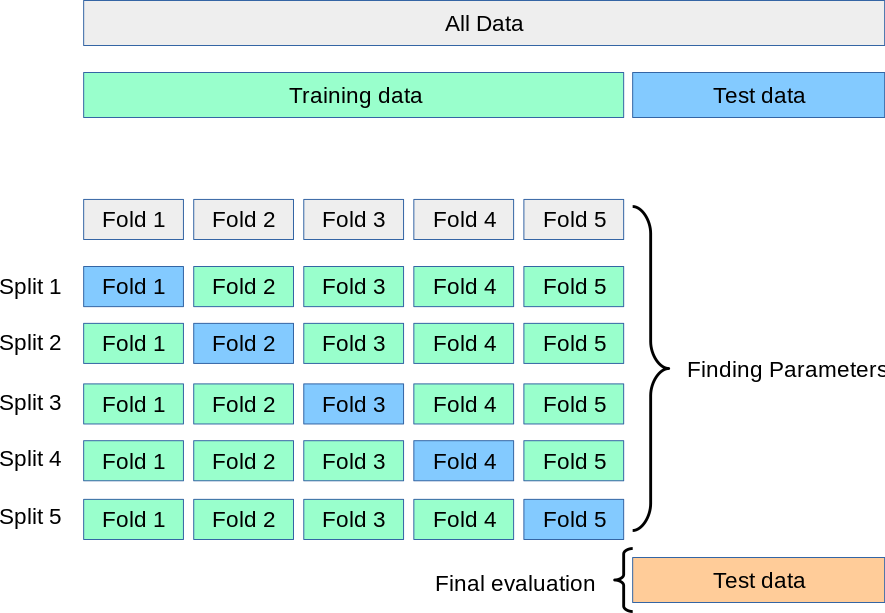

Above is a visual depiction of a 5-fold cross validation. After all folds are done, we can take the mean of the scores as the final, most realistic performance of the model.

Let's perform this process in code using the `cv` function of `xgb`:

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 1000

results = xgb.cv(
    params, dtrain_reg, 
    num_boost_round=n, 
    nfold=5,
    early_stopping_rounds=20
)
```

The only difference with the `train` function is adding the `nfold` parameter to speficy the number of splits. The `results` object is now a DataFrame containing each fold's results:

```python
results.head()
```

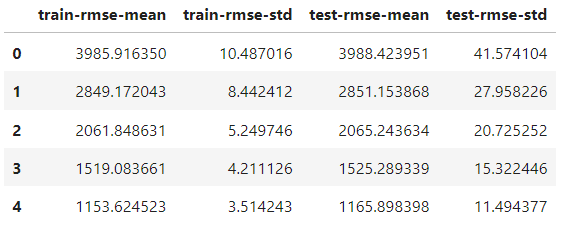

It has the same number of rows as the number of boosting rounds. Each row is the average of all splits for that round. So, to find the best score, we take the minimum of the `test-rmse-mean` column:

```python
best_rmse = results['test-rmse-mean'].min()

best_rmse
```

```
550.8959336674216
```

Note that this method of cross-validation is used to see the true performance of the model. Once you are satisfied with its score, you have to retrain it one final time on the __full data__ before deployment.

## Classification in XGBoost

Building an XGBoost classifier is as easy as changing the objective function, the rest can stay the same. 

The two most popular classification objectives are:

- `binary:logistic` - binary classification (the target contains only two classes, i.e. cat or dog)
- `multi:softprob` - multi-class classification (more than two classes in the target, i.e. apple/orange/banana)

Performing binary and multi-class classification in XGBoost is almost identical, so we will go with the latter. Let's prepare the data for the task first. 

We want to predict the cut quality of diamonds given their price and its physical measurements. So, we will build the feature/target arrays accordingly:

```python
from sklearn.preprocessing import OrdinalEncoder

X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
    X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)
```

The only difference is that since XGBoost only accepts numbers in the target, we are encoding the text classes in the target with OrdinalEncoder of Sklearn.

Now, we build the DMatrices...

```python
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
```

...and set the objective to `multi:softprob`. This objective also requires the number of classes to be set by us:

```python
params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 5}
n = 1000

results = xgb.cv(
    params, dtrain_clf, 
    num_boost_round=n, 
    nfold=5,
    metrics=["mlogloss", "auc", "merror"],
)
```

During cross-validation, we are asking XGBoost to watch three classification metrics which report model performance from three different angles. Here is the result:

```
results.keys()
```

```
Index(['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean',
       'train-auc-std', 'train-merror-mean', 'train-merror-std',
       'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean',
       'test-auc-std', 'test-merror-mean', 'test-merror-std'],
      dtype='object')
```

To see the best AUC score, we take the maximum of `test-auc-mean` column:

```
>>> results['test-auc-mean'].max()
```

```
0.9402233623451636
```

Even the default configuration gave us 94% performance, which is great.

## XGBoost native vs. XGBoost Sklearn
So far, we have been using the native XGBoost API but its Sklearn API is pretty popular as well. 

Sklearn is a vast framework with many machine learning algorithms and utilities and has an API syntax loved by almost everyone. Therefore, XGBoost also offers XGBClassifier and XGBRegressor classes so that they can be integrated into the Sklearn ecosystem (at the loss of some of the functionality).

If you want to only use the Scikit-learn API whenever possible and only switch to native when you need access to extra functionality, there is a way. 

After training XGBoost classifier or regressor, you can convert it using the `get_booster` method:

```python
import xgboost as xgb

# Train a model using the scikit-learn API
xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3)
xgb_classifier.fit(X_train, y_train)

# Convert the model to a native API model
model = xgb_classifier.get_booster()
```

The `model` object will behave in the exact same way we've seen throughout this tutorial.

## Wrap

Finally, the end. We've covered a lot of important topics but there are still so many things to learn. 

Specifically, check out the [XGBoost parameters page](https://xgboost.readthedocs.io/en/stable/parameter.html) which teaches you how to configure the parameters to squeeze out every last performance from your models. 

Also check out the official [XGBoost tutorials section](https://xgboost.readthedocs.io/en/stable/tutorials/index.html) where you can learn many tricks and best practices of using the library. 

Thank you for reading!